In [42]:
import pandas as pd
import numpy as np
import hdbscan
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import os
from tqdm import tqdm
import umap
import seaborn as sns

In [2]:
N_COMPONENTS = 1
INPUT_DIR = 'datasets/Anonimized/'

In [3]:
# stop_columns = ['№', 'Компатриоты', 'Unnamed: 4', 'Название команды', 'ФИО участников', 'ФИО', 'Компетенция', 'Баллы, ед.', 'Баллы по ключевым навыкам', 'Максимальное значение']
stop_columns = ['№', 'Компатриоты', 'Unnamed: 4', 'Название команды', 'ФИО участников', 'ФИО', 'Компетенция', 'Баллы, ед.', 'Баллы, %','Баллы по ключевым навыкам', 'Максимальное значение']

In [43]:
def data_prep(files_names):
    full_data = pd.DataFrame(columns=['ФИО', 'Компетенция'] + [f'feat_{i}' for i in range(N_COMPONENTS)])

    for filename in tqdm(files_names):
        data = pd.read_csv(INPUT_DIR + filename)
        if 'ФИО' in data.columns:
            fio = data['ФИО']
        else:
            fio = data['ФИО участников']
        comp = data['Компетенция']
        if data['Баллы, %'].isna().sum() != 0 and data['Баллы, ед.'].isna().sum() == 0:
            data['Баллы, %'] = data['Баллы, ед.']
        elif data['Баллы, %'].isna().sum() != 0 and data['Баллы по ключевым навыкам'].isna().sum() == 0:
            data['Баллы, %'] = data['Баллы по ключевым навыкам']
        score = data['Баллы, %'].apply(lambda x: x.replace(',','.').replace('%', '')).astype(float)
        for column in stop_columns:
            if column in data.columns:
                data = data.drop(column, axis=1)
        data = data.dropna(axis=1, how='all')
        float_columns = data.select_dtypes(include=[object]).apply(lambda x: x.str.replace(',','.').str.replace('%', '')).astype(float)
        int_columns = data.select_dtypes(include=['int'])
        data = pd.concat([float_columns, int_columns], axis=1)
        scaler = StandardScaler()
        data = scaler.fit_transform(data)
        data = np.nan_to_num(data, nan=0)
        pca = PCA(n_components=N_COMPONENTS)
        scaler = MinMaxScaler(feature_range=(-20, 20))
        score_scaled = scaler.fit_transform(score.to_numpy().reshape(-1, 1))
        data_reduced = pca.fit_transform(data)
        data_reduced = pd.DataFrame(data_reduced, columns = [f'feat_{i}' for i in range(N_COMPONENTS)])
        data_reduced['ФИО'], data_reduced['Компетенция'], data_reduced['score'] = fio, comp, score_scaled
        full_data = pd.concat([data_reduced, full_data], axis=0)
    return full_data

In [44]:
file_list = os.listdir(INPUT_DIR)
full_data = data_prep(file_list)

100%|██████████| 39/39 [00:02<00:00, 15.50it/s]


In [45]:
full_data

,feat_0,ФИО,Компетенция,score
0,-3.947337,ФИО_478; ФИО_123; ФИО_220,Бетонные строительные работы,14.738595
1,-5.327404,ФИО_330; ФИО_564; ФИО_573,Бетонные строительные работы,20.000000
2,-3.057025,ФИО_175; ФИО_332; ФИО_344,Бетонные строительные работы,5.281385
3,0.092196,ФИО_173; ФИО_617; ФИО_708,Бетонные строительные работы,-4.775225
4,12.239570,ФИО_205; ФИО_671; ФИО_674,Бетонные строительные работы,-20.000000
...,...,...,...,...
4,-1.397307,ФИО_75; ФИО_236; ФИО_363; ФИО_383; ФИО_561; ФИ...,Управление жизненным циклом,1.350434
5,0.732136,ФИО_165; ФИО_372; ФИО_413; ФИО_513; ФИО_568; Ф...,Управление жизненным циклом,-9.151264
6,7.927428,ФИО_25; ФИО_224; ФИО_565; ФИО_574; ФИО_603; ФИ...,Управление жизненным циклом,-15.986420
7,6.105891,ФИО_33; ФИО_66; ФИО_80; ФИО_234; ФИО_320; ФИО_...,Управление жизненным циклом,-18.777820


In [46]:
# loh = full_data.iloc[:, 0:N_COMPONENTS]
loh = full_data.iloc[:, [0, -1]]
loh.describe()

,feat_0,score
count,4.500000e+02,450.000000
mean,-6.315935e-17,-0.549276
std,6.774351e+00,13.047248
min,-1.520420e+01,-20.000000
25%,-4.950782e+00,-12.284908
50%,-9.491644e-01,-0.111563
75%,4.571988e+00,9.875143
max,2.600110e+01,20.000000


/tmp/ipykernel_33297/437510255.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loh['labels'] = cluster.labels_


ValueError: 'c' argument has 289 elements, which is inconsistent with 'x' and 'y' with size 161.

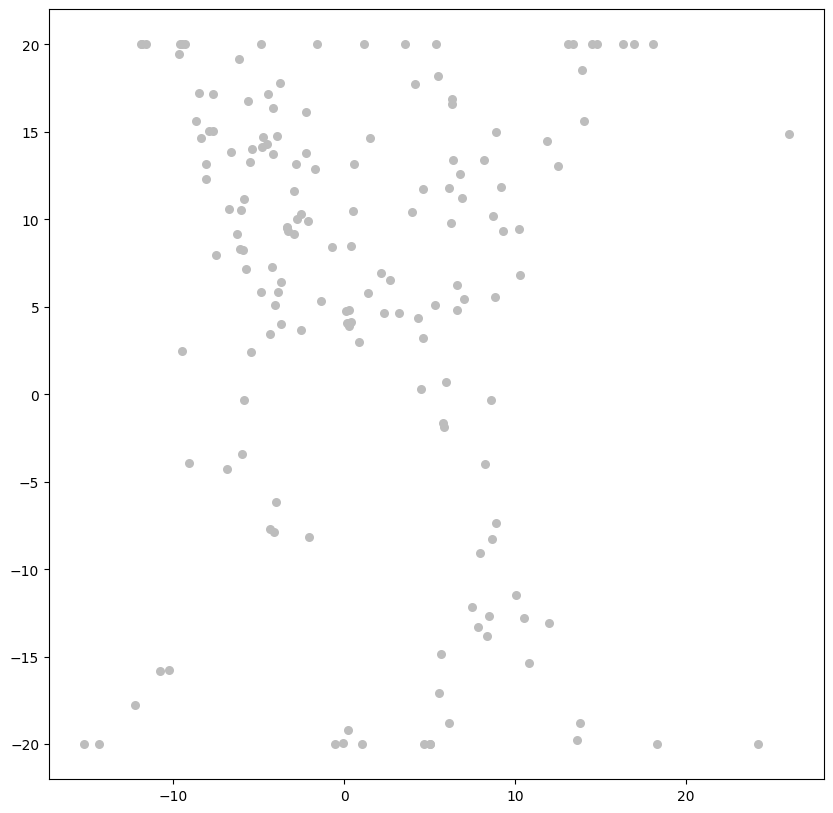

In [52]:
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                        metric='euclidean',                   
                        cluster_selection_method='eom').fit(loh)
loh['labels'] = cluster.labels_

fig, ax = plt.subplots(figsize=(10, 10))
outliers = loh.loc[loh.labels == -1, :]
clustered = loh.loc[loh.labels != -1, :]

plt.scatter(outliers.feat_0, outliers.score, color='#BDBDBD', s=30)
plt.scatter(outliers.feat_0, outliers.score, c=clustered.labels, 
s=30, cmap='hsv_r')

plt.colorbar()

In [53]:
loh['labels'].value_counts()

labels
-1    161
 1    117
 5     96
 4     22
 0     20
 3     19
 2     15
Name: count, dtype: int64